<a href="https://colab.research.google.com/github/Wycliff-Kimani/AgroAI-Model/blob/main/AgroAImainModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile

# Creaing the Kaggle directory and move kaggle.json
os.makedirs("/root/.kaggle", exist_ok=True)
!cp kaggle.json /root/.kaggle/
os.chmod("/root/.kaggle/kaggle.json", 600)
print("Done")

Done


In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset


Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
 97% 2.62G/2.70G [00:24<00:01, 44.8MB/s]
100% 2.70G/2.70G [00:24<00:00, 116MB/s] 


In [ ]:
with zipfile.ZipFile("new-plant-diseases-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/plant_dataset")


In [ ]:
import os

root_dir = "/content/plant_dataset"

# Recursively print all subdirectories under the root
for root, dirs, files in os.walk(root_dir):
    level = root.replace(root_dir, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    for d in dirs:
        print(f"{indent}    {d}/")


plant_dataset/
    new plant diseases dataset(augmented)/
    test/
    New Plant Diseases Dataset(Augmented)/
    new plant diseases dataset(augmented)/
        New Plant Diseases Dataset(Augmented)/
        New Plant Diseases Dataset(Augmented)/
            valid/
            train/
            valid/
                Apple___healthy/
                Apple___Apple_scab/
                Grape___healthy/
                Potato___Late_blight/
                Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/
                Pepper,_bell___Bacterial_spot/
                Corn_(maize)___healthy/
                Cherry_(including_sour)___Powdery_mildew/
                Strawberry___healthy/
                Raspberry___healthy/
                Tomato___Tomato_mosaic_virus/
                Tomato___Early_blight/
                Potato___healthy/
                Peach___healthy/
                Corn_(maize)___Common_rust_/
                Peach___Bacterial_spot/
                Squash___Powde

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)

# Data transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset paths (inspect manually to confirm correct path)
train_dir = "/content/plant_dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train"
val_dir = "/content/plant_dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Class summary and sample batch check
class_names = train_dataset.classes
print(f"Total classes: {len(class_names)}")
print("Sample classes:", class_names[:5])

features, labels = next(iter(train_loader))
print(f"Feature batch shape: {features.shape}")
print(f"Label batch shape: {labels.shape}")


Device in use: cuda
Total classes: 38
Sample classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']
Feature batch shape: torch.Size([32, 3, 256, 256])
Label batch shape: torch.Size([32])


In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
import torch.optim as optim

# Load pretrained ResNet18
model = resnet18(weights=ResNet18_Weights.DEFAULT)

# Replace the final layer to match 38 output classes
model.fc = nn.Linear(model.fc.in_features, len(class_names))

# Move model to the selected device (CPU or GPU)
model = model.to(device)

print("Model loaded and modified for 38-class classification.")

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Loss function and optimizer configured.")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 223MB/s]

Model loaded and modified for 38-class classification.
Loss function and optimizer configured.


In [ ]:
import os
import shutil

# Corrected source dataset dirs
original_train_dir = "/content/plant_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
original_val_dir = "/content/plant_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"

# Filtered dataset output dirs
filtered_train_dir = "/content/kenya_dataset/train"
filtered_val_dir = "/content/kenya_dataset/valid"

# Verified relevant classes (Kenyan crops only)
relevant_classes = [
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___Northern_Leaf_Blight",
    "Corn_(maize)___healthy",
    "Potato___Early_blight",
    "Potato___Late_blight",
    "Potato___healthy",
    "Tomato___Bacterial_spot",
    "Tomato___Early_blight",
    "Tomato___Late_blight",
    "Tomato___Leaf_Mold",
    "Tomato___Septoria_leaf_spot",
    "Tomato___Spider_mites Two-spotted_spider_mite",
    "Tomato___Tomato_mosaic_virus",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
    "Tomato___healthy",
    "Pepper,_bell___Bacterial_spot",
    "Soybean___healthy"
]

# Copying only the selected class folders to new structure
def copy_filtered_classes(source_dir, target_dir, class_list):
    os.makedirs(target_dir, exist_ok=True)
    for cls in class_list:
        src_path = os.path.join(source_dir, cls)
        dst_path = os.path.join(target_dir, cls)
        if os.path.exists(src_path):
            shutil.copytree(src_path, dst_path)
            print(f"Copied slasses: {cls}")
        else:
            print(f"Skipped (not found): {cls}")

# Run copy for train and val
copy_filtered_classes(original_train_dir, filtered_train_dir, relevant_classes)
copy_filtered_classes(original_val_dir, filtered_val_dir, relevant_classes)

print("Filtered Kenya based localised dataset is ready.")


Copied slasses: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Copied slasses: Corn_(maize)___Common_rust_
Copied slasses: Corn_(maize)___Northern_Leaf_Blight
Copied slasses: Corn_(maize)___healthy
Copied slasses: Potato___Early_blight
Copied slasses: Potato___Late_blight
Copied slasses: Potato___healthy
Copied slasses: Tomato___Bacterial_spot
Copied slasses: Tomato___Early_blight
Copied slasses: Tomato___Late_blight
Copied slasses: Tomato___Leaf_Mold
Copied slasses: Tomato___Septoria_leaf_spot
Copied slasses: Tomato___Spider_mites Two-spotted_spider_mite
Copied slasses: Tomato___Tomato_mosaic_virus
Copied slasses: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Copied slasses: Tomato___healthy
Copied slasses: Pepper,_bell___Bacterial_spot
Copied slasses: Soybean___healthy
Copied slasses: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Copied slasses: Corn_(maize)___Common_rust_
Copied slasses: Corn_(maize)___Northern_Leaf_Blight
Copied slasses: Corn_(maize)___healthy
Copied slasses: Pot

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)

# Paths to filtered dataset
train_dir = "/content/kenya_dataset/train"
val_dir = "/content/kenya_dataset/valid"

# Image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

print("Done")

Device in use: cuda
Done


In [ ]:
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

# Class names and count
class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Classes: {num_classes}")
print("Sample classes:", class_names[:5])

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=False)


print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Classes found: {len(train_dataset.classes)}")
print("First few classes:", train_dataset.classes[:5])

Classes: 18
Sample classes: ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Pepper,_bell___Bacterial_spot']
Training samples: 33471
Validation samples: 8366
Classes found: 18
First few classes: ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Pepper,_bell___Bacterial_spot']


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights

# Define the model and modify final layer
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 18)  # 18 classes

# Send model to device
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model initialized with 18 output classes.")


Model initialized with 18 output classes.


In [ ]:
import time

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    duration = time.time() - start_time

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Time: {duration:.2f}s")
print("Training is doen. Save the model")

Epoch [1/10] - Loss: 0.2584, Accuracy: 91.55%, Time: 172.46s
Epoch [2/10] - Loss: 0.1123, Accuracy: 96.21%, Time: 173.20s
Epoch [3/10] - Loss: 0.0810, Accuracy: 97.33%, Time: 173.53s
Epoch [4/10] - Loss: 0.0667, Accuracy: 97.75%, Time: 174.00s
Epoch [5/10] - Loss: 0.0585, Accuracy: 98.13%, Time: 173.36s
Epoch [6/10] - Loss: 0.0558, Accuracy: 98.22%, Time: 173.13s
Epoch [7/10] - Loss: 0.0411, Accuracy: 98.69%, Time: 173.79s
Epoch [8/10] - Loss: 0.0406, Accuracy: 98.70%, Time: 174.66s
Epoch [9/10] - Loss: 0.0399, Accuracy: 98.76%, Time: 173.80s


In [ ]:
# Save to local session
torch.save(model.state_dict(), "kenya_agroai_resnet18.pth")
print("Model saved locally as 'kenya_agroai_resnet18.pth'")

# Save to Drive
drive_path = "/content/drive/MyDrive/kenya_agroai_resnet18.pth"
torch.save(model.state_dict(), drive_path)
print(f"Model also saved to Drive at: {drive_path}")
drive_path = "/content/drive/MyDrive/agroai_kenya_resnet18.pth"
torch.save(model.state_dict(), drive_path)
print(f"Model also saved to Drive at: {drive_path}")


Model saved locally as 'kenya_agroai_resnet18.pth'
Model also saved to Drive at: /content/drive/MyDrive/kenya_agroai_resnet18.pth
Model also saved to Drive at: /content/drive/MyDrive/agroai_kenya_resnet18.pth


In [ ]:
from google.colab import files
files.download("kenya_agroai_resnet18.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save full model (.pt)
torch.save(model, "kenya_agroai_resnet18pt_version.pt")


In [ ]:
files.download("kenya_agroai_resnet18pt_version.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save to Drive
drive_path = "/content/kenya_agroai_resnet18pt_version.pt"
torch.save(model.state_dict(), drive_path)
print(f"Model also saved to Drive at: {drive_path}")

Model also saved to Drive at: /content/kenya_agroai_resnet18pt_version.pt


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

val_accuracy = 100. * correct / total
print(f"Validation Accuracy: {val_accuracy:.2f}%")


Validation Accuracy: 98.54%


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

# Define device again
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)

# Load model structure
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 18)  # 18 classes

# Load trained weights
model.load_state_dict(torch.load("/content/drive/MyDrive/kenya_agroai_resnet18.pth", map_location=device))
model = model.to(device)
model.eval()

print("Model loaded successfully and ready for inference.")


Device in use: cuda
Model loaded successfully and ready for inference.


In [ ]:
import os

source_test_dir = "/content/plant_dataset/test/test"
all_test_images = [f for f in os.listdir(source_test_dir) if f.endswith(".JPG")]

print(f"Total test images found: {len(all_test_images)}")
print("Sample files:", all_test_images[:5])


Total test images found: 33
Sample files: ['TomatoYellowCurlVirus6.JPG', 'PotatoHealthy1.JPG', 'TomatoYellowCurlVirus1.JPG', 'AppleScab1.JPG', 'AppleCedarRust1.JPG']


In [ ]:
import random
import shutil
import os

# Source test images directory
source_test_dir = "/content/plant_dataset/test/test"

# Destination folder for selected samples
sample_output_dir = "/content/test_samples"
os.makedirs(sample_output_dir, exist_ok=True)

# Get .JPG images only
all_test_images = [f for f in os.listdir(source_test_dir) if f.endswith(".JPG")]

# Randomly select 10
selected_images = random.sample(all_test_images, 10)

# Copy selected images to test_samples/
for img_name in selected_images:
    src_path = os.path.join(source_test_dir, img_name)
    dst_path = os.path.join(sample_output_dir, img_name)
    shutil.copy2(src_path, dst_path)
    print(f"Copied: {img_name}")

print(f"\nCopied {len(selected_images)} images to: {sample_output_dir}")


Copied: PotatoEarlyBlight2.JPG
Copied: TomatoYellowCurlVirus5.JPG
Copied: PotatoEarlyBlight4.JPG
Copied: PotatoHealthy2.JPG
Copied: TomatoYellowCurlVirus2.JPG
Copied: TomatoEarlyBlight1.JPG
Copied: AppleCedarRust2.JPG
Copied: TomatoYellowCurlVirus1.JPG
Copied: TomatoHealthy4.JPG
Copied: CornCommonRust3.JPG

Copied 10 images to: /content/test_samples


In [ ]:
# These are the 18 Kenyan classes used in training, in correct alphabetical order
kenya_classes = sorted([
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___Northern_Leaf_Blight",
    "Corn_(maize)___healthy",
    "Pepper,_bell___Bacterial_spot",
    "Potato___Early_blight",
    "Potato___Late_blight",
    "Potato___healthy",
    "Soybean___healthy",
    "Tomato___Bacterial_spot",
    "Tomato___Early_blight",
    "Tomato___Late_blight",
    "Tomato___Leaf_Mold",
    "Tomato___Septoria_leaf_spot",
    "Tomato___Spider_mites Two-spotted_spider_mite",
    "Tomato___Tomato_mosaic_virus",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
    "Tomato___healthy"
])


In [ ]:
import os
import json

# Extract class names from filtered training dataset
filtered_train_path = "/content/kenya_dataset/train"
kenya_class_names = sorted(os.listdir(filtered_train_path))

# Display
print("Detected classes:", len(kenya_class_names))
print(kenya_class_names)

# Save to JSON for future reuse
with open("kenya_class_names.json", "w") as f:
    json.dump(kenya_class_names, f)

print("Saved class names to 'kenya_class_names.json'")


Detected classes: 18
['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Pepper,_bell___Bacterial_spot', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Soybean___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Saved class names to 'kenya_class_names.json'


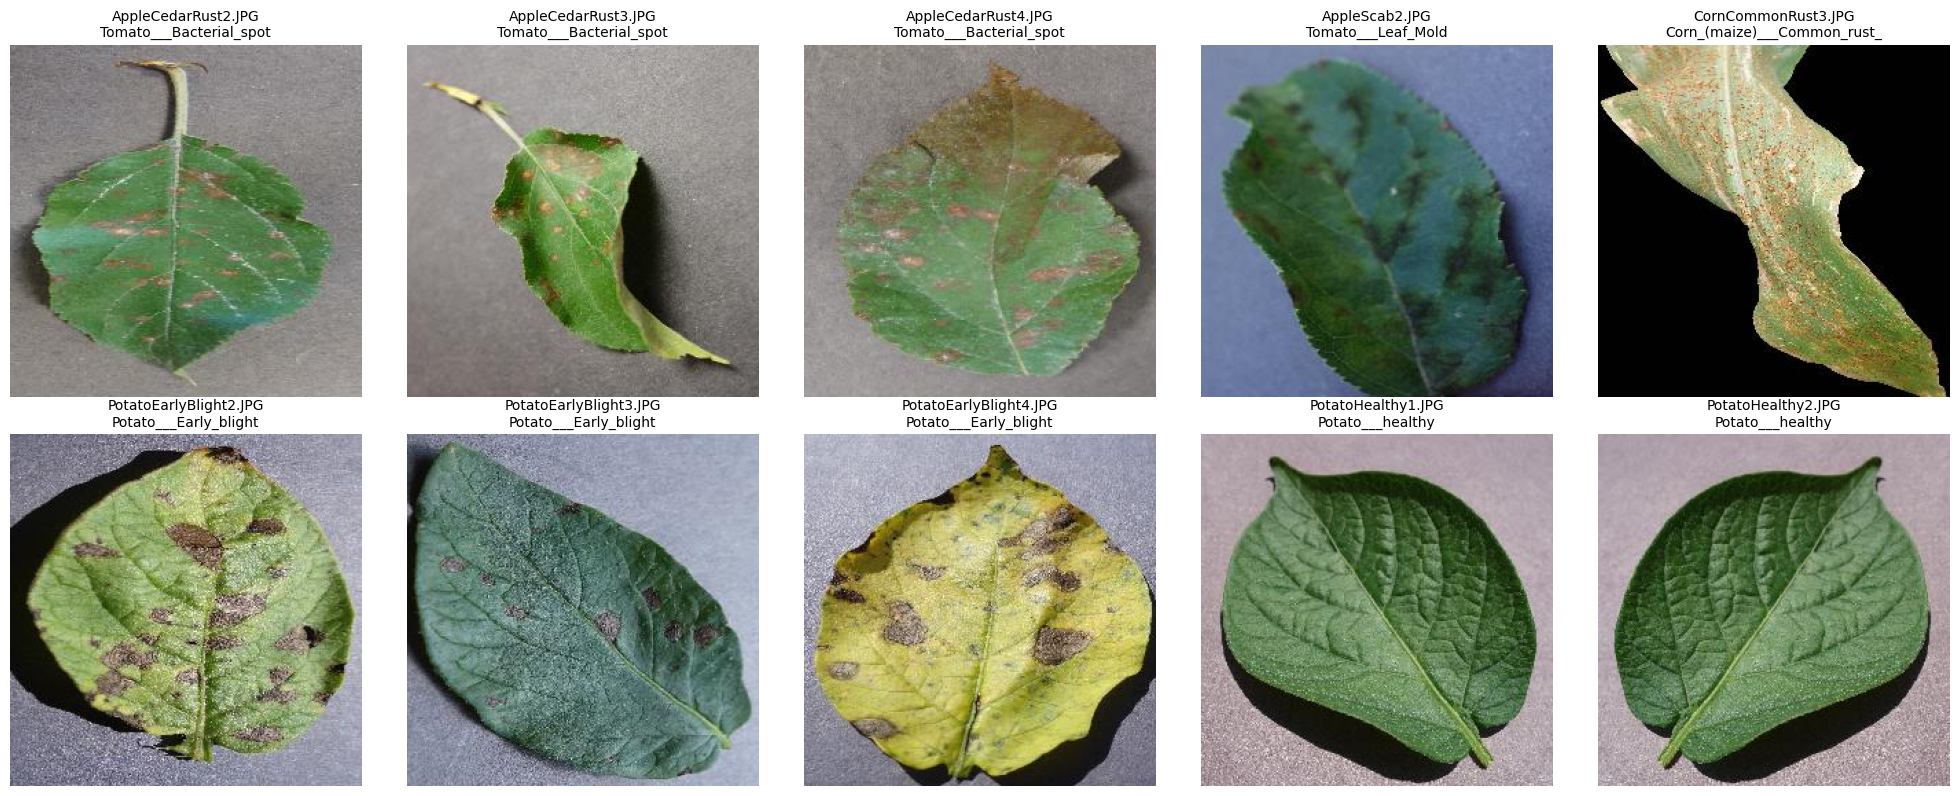

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import os
import json

# Load class names
with open("kenya_class_names.json", "r") as f:
    kenya_class_names = json.load(f)

# Image folder
test_img_dir = "/content/test_samples"

# Image transform (must match training)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load model and weights
model_path = "/content/drive/MyDrive/kenya_agroai_resnet18.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Predict on test images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, img_name in enumerate(sorted(os.listdir(test_img_dir))[:10]):
    img_path = os.path.join(test_img_dir, img_name)
    img = Image.open(img_path).convert("RGB")

    input_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        pred_class = kenya_class_names[predicted.item()]

    axes[idx].imshow(img)
    axes[idx].set_title(f"{img_name}\n{pred_class}", fontsize=10)
    axes[idx].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import shutil

old_test_dir = "/content/test_samples"

# Delete old test folder if it exists
if os.path.exists(old_test_dir):
    shutil.rmtree(old_test_dir)
    print(f"Deleted old test folder: {old_test_dir}")
else:
    print("No old test folder found.")


Deleted old test folder: /content/test_samples


In [ ]:
import os
import shutil
import random

# Source: Kenya validation dataset
val_base_dir = "/content/kenya_dataset/valid"
test_sample_dir = "/content/kenya_test_samples"
os.makedirs(test_sample_dir, exist_ok=True)

# Clear it in case it already has old files
for f in os.listdir(test_sample_dir):
    os.remove(os.path.join(test_sample_dir, f))

# Get all subfolders (class names)
class_folders = [os.path.join(val_base_dir, c) for c in os.listdir(val_base_dir) if os.path.isdir(os.path.join(val_base_dir, c))]

# Gather all image paths
all_images = []
for folder in class_folders:
    images = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(".jpg")]
    if images:
        all_images.extend(images)

# Randomly pick 10 images
selected_images = random.sample(all_images, 10)

# Copy to test_samples folder
for path in selected_images:
    filename = os.path.basename(path)
    dest = os.path.join(test_sample_dir, filename)
    shutil.copy(path, dest)
    print(f"Copied: {filename}")

print("10 test images copied to:", test_sample_dir)


Copied: 1994cd3e-4000-4c56-bede-d35a1eecc287___RS_Early.B 6867_180deg.JPG
Copied: f4f56f28-479b-4e71-afb2-210e668a411e___GCREC_Bact.Sp 3537.JPG
Copied: 974a15f0-913a-41ab-b5a4-30015f159902___GHLB2 Leaf 8792.JPG
Copied: 5c339413-2b34-4c09-8343-c88e216a29eb___RS_NLB 4193.JPG
Copied: 87884ea0-dceb-421c-b6c1-a876232cd142___Matt.S_CG 1019.JPG
Copied: d886ffed-a35b-4954-9066-b708c34fc998___GHLB2 Leaf 82.1.JPG
Copied: 9a6eb7c4-6b43-477a-89e0-69f62ef67991___RS_HL 1846_new90degFlipLR.JPG
Copied: 8289c053-a0c4-4740-9fd8-fd316b6f5688___JR_B.Spot 3299_180deg.JPG
Copied: 2d691af4-7e00-47ef-bf2a-077b6c536881___R.S_HL 5543 copy 2_flipLR.jpg
Copied: 7944b10d-96b5-4219-882d-22b1e2380544___RS_GLSp 7309.JPG
✅ 10 test images copied to: /content/kenya_test_samples


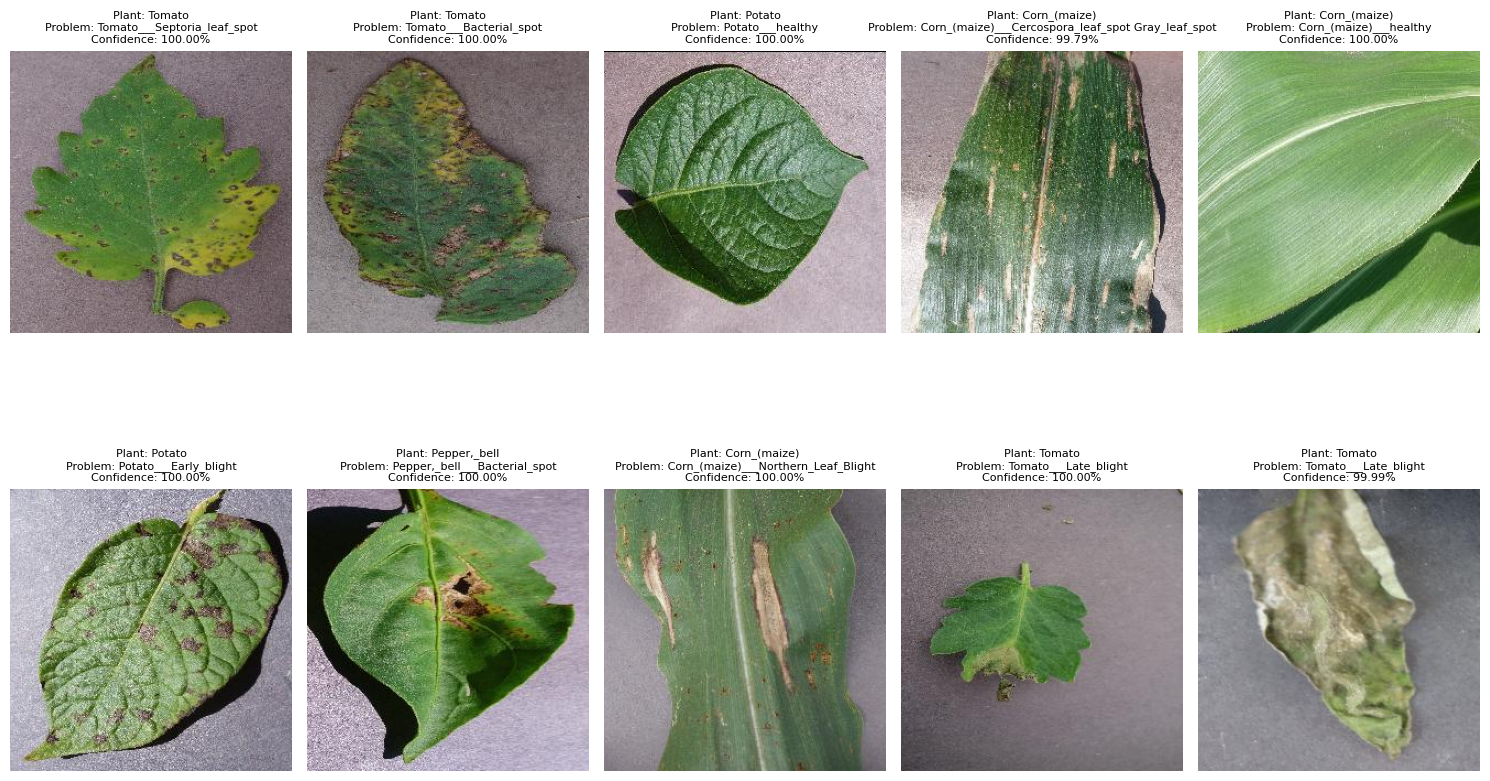

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import json
import os

# Load class names
with open("kenya_class_names.json", "r") as f:
    class_names = json.load(f)

# Load model
from torchvision.models import resnet18
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load("kenya_agroai_resnet18.pth", map_location=device))
model.to(device)
model.eval()

# Image transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Folder with test images
test_folder = "/content/kenya_test_samples"
image_files = [f for f in os.listdir(test_folder) if f.lower().endswith(".jpg")]

# Plot predictions
plt.figure(figsize=(15, 10))

for idx, img_file in enumerate(image_files):
    img_path = os.path.join(test_folder, img_file)
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probs, 1)
        predicted_class = class_names[predicted.item()]
        confidence_pct = confidence.item() * 100

    # Extract plant name before the triple underscores
    plant_name = predicted_class.split("___")[0]
    problem = predicted_class

    # Display results
    plt.subplot(2, 5, idx + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(
        f"Plant: {plant_name}\nProblem: {problem}\nConfidence: {confidence_pct:.2f}%",
        fontsize=8
    )

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Store predictions
predictions = []

# Loop again for text output
for img_file in image_files:
    img_path = os.path.join(test_folder, img_file)
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probs, 1)
        predicted_class = class_names[predicted.item()]
        confidence_pct = confidence.item() * 100

    plant = predicted_class.split("___")[0]
    problem = predicted_class

    predictions.append({
        "Image": img_file,
        "Plant": plant,
        "Problem": problem,
        "Confidence (%)": f"{confidence_pct:.2f}"
    })

# Convert to DataFrame
df = pd.DataFrame(predictions)

# Save to CSV
csv_path = "/content/test_predictions_summary.csv"
df.to_csv(csv_path, index=False)
print(f"Summary saved to: {csv_path}")


Summary saved to: /content/test_predictions_summary.csv


In [ ]:
# Disease to recommendation mapping
recommendation_map = {
    "Tomato___Early_blight": "Use copper-based fungicides and remove affected leaves.",
    "Tomato___Bacterial_spot": "Apply bactericides and avoid overhead irrigation.",
    "Tomato___Leaf_Mold": "Increase air circulation and apply fungicides.",
    "Tomato___healthy": "No action needed.",
    "Corn_(maize)___Common_rust_": "Apply fungicides and grow resistant maize varieties.",
    "Corn_(maize)___Northern_Leaf_Blight": "Use certified seed and rotate crops.",
    "Corn_(maize)___healthy": "No issues detected.",
    "Potato___Early_blight": "Use mancozeb or chlorothalonil fungicides.",
    "Potato___healthy": "No action needed.",
    "Potato___Late_blight": "Use metalaxyl-based fungicides and ensure good drainage.",
    "Pepper,_bell___Bacterial_spot": "Avoid working when plants are wet and apply copper sprays.",
    "Soybean___healthy": "No action needed.",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus": "Remove infected plants and control whiteflies.",
    "Tomato___Tomato_mosaic_virus": "Destroy infected plants and disinfect tools.",
    "Tomato___Septoria_leaf_spot": "Prune infected leaves and apply fungicide.",
    "Tomato___Spider_mites Two-spotted_spider_mite": "Use miticides or neem oil."
}

# Attach recommendations to prediction DataFrame
df["Recommendation"] = df["Problem"].map(recommendation_map).fillna("No recommendation available.")

# Save enhanced summary
recommendations_csv_path = "/content/test_predictions_with_recommendations.csv"
df.to_csv(recommendations_csv_path, index=False)
print(f"Enhanced summary with recommendations saved to: {recommendations_csv_path}")


Enhanced summary with recommendations saved to: /content/test_predictions_with_recommendations.csv
